# Comparison with TLS

## Simulating data

In [1]:
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import sys
import nuance
import simulation
import pandas as pd
from nuance.utils import protopapas2005 as transit
import celerite2
from celerite2 import terms
from nuance import Nuance
from wotan import flatten
from nuance.tls import TLS
from tqdm import tqdm
from datetime import datetime

In [2]:
%config IPCompleter.use_jedi = False
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

In [3]:
df = []
search_results = {}

In [4]:
time = np.linspace(0, 10, 1000) + 0.23

# transit
true_t0 = 0
true_duration = 0.04
true_depth = 1e-2
true_period = 3
error = 1e-3

X = np.vstack([
    np.ones_like(time),
    time,
    time**2,
    np.sin(2*np.pi*0.5*time)
])


def sim(
    time, 
    true_t0,
    true_duration,
    true_depth,
    true_period,
    error,
    relative_duration,
    relative_depth,
    term,
    seed,
):
    if term == "Matern32Term":
        _term = terms.Matern32Term(sigma=relative_depth*true_depth, rho=true_duration*relative_duration)
    elif term == "SHOTerm":
        _term = terms.SHOTerm(sigma=relative_depth*true_depth/relative_duration, tau=true_duration*relative_duration, rho=1)
    syst = [1., 1e-3, 3e-4, 4e-3]@X

    flux = simulation.simulate_lc(time, true_t0, true_duration, true_depth, true_period, _term, error, syst)

    search_results = {
        "times": len(time),
        "dt": np.median(np.diff(time)),
        "true_t0": true_t0,
        "true_duration": true_duration,
        "true_depth": true_depth,
        "true_period": true_period,
        "error": error,
        "relative_duration": relative_duration,
        "relative_depth": relative_depth,
        "term": term,
        "seed": seed
    }
    
    return flux, error, _term, search_results

Text(0.5, 1.0, '2.27 x depth, 2.09 x duration ')

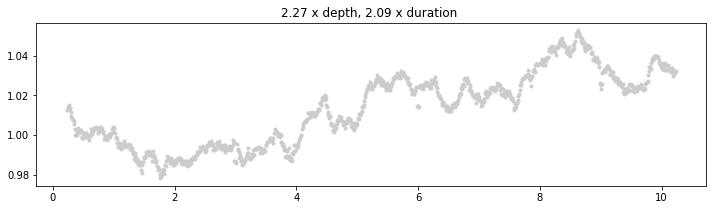

In [5]:
seed = np.random.randint(0, int(2**32 - 1))
np.random.seed(seed)
relative_duration = np.random.uniform(0.1, 10)
relative_depth = np.random.uniform(0.1, 5)

flux, err, term, s = sim(time, true_t0, true_duration, true_depth, true_period, error, relative_duration, relative_depth, "SHOTerm", seed)

plt.figure(None, (12, 3))
plt.plot(time, flux, ".", c="0.8")
plt.title(f"{relative_depth:.2f} x depth, {relative_duration:.2f} x duration ")

## Search

In [6]:
periods = np.linspace(1, 10, 1000)

In [7]:
def right_candidate(t0, period, verbose=True):
    t0_check = np.abs((t0  - true_t0 + 0.5 * true_period) % true_period - 0.5 * true_period)%period < 0.01
    period_check = np.abs(period - true_period) < 0.1
    same = np.logical_and(t0_check, period_check)
    if verbose:
        if not same:
            if not t0_check:
                print(f"t0 differ: {t0:.2e} {true_t0:.2e}")
            if not period_check:
                print(f"period differ: {period:.2e} {true_period:.2e}")

    return same

### nuance search

In [8]:
nu = Nuance(time, flux, error)
nu.linear_search(X, term=term)
nu.periodic_search(periods)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 779.98it/s]


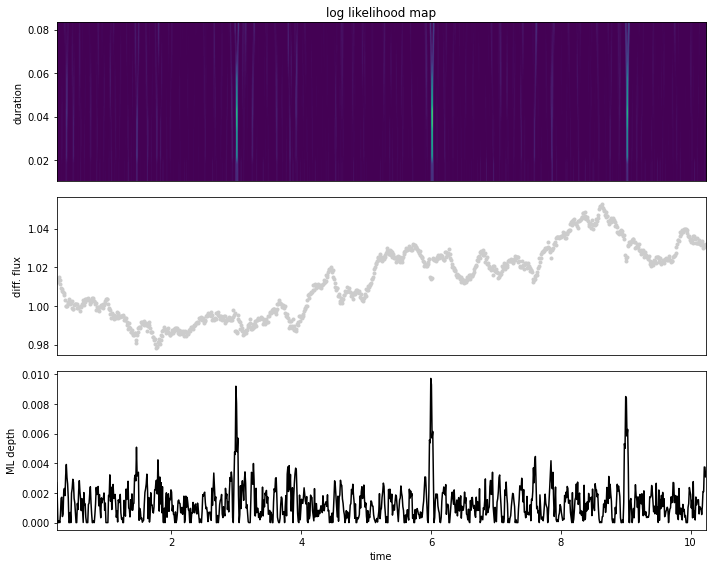

In [9]:
nu.plot_linear_search()

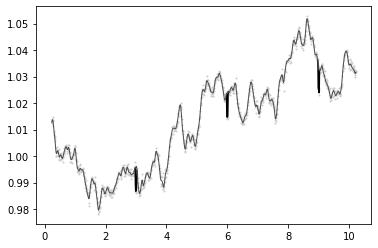

In [10]:
_, t0, duration, depth, period  = nu.best_candidate()
is_detected = right_candidate(t0, period)

search_results.update({
    "nuance_t0": t0,
    "nuance_period": period,
    "nuance_detected": is_detected
})

linear, astro, noise = nu.solver.model(m=transit(nu.time, t0, duration, depth, period=period))
plt.plot(nu.time, nu.flux, ".", c="0.8", ms=2)
model = astro + noise + linear
model[astro > -1e-8] = np.nan
plt.plot(time, model, c="k")
plt.plot(time, noise + linear, c="0.3", lw=1)

Planet found:
SNR: 13.42 
period: 3.00 days
duration: 60.00 minutes
depth: 7.93 ppt




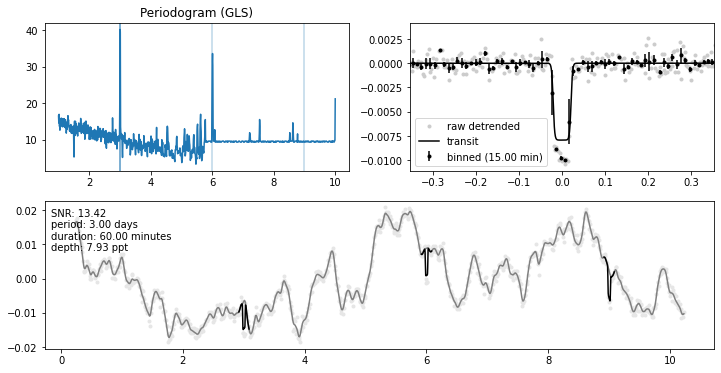

In [11]:
nu.plot_best_candidate()

### wotan + TLS search

In [12]:
flatten_flux, flatten_trend = flatten(time, flux, window_length=3*true_duration, return_trend=True)

In [13]:
model = TLS(time, flatten_flux, verbose=False)
results = model.power(periods, verbose=False)

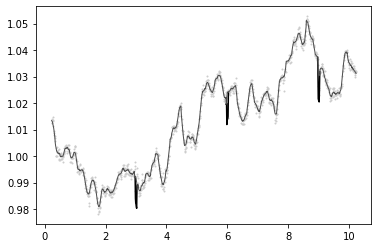

In [14]:
t0 = results["T0"]
period = results["period"]
is_detected = right_candidate(t0, period)

search_results.update({
    "wotan+tls_t0": t0,
    "wotan+tls_period": period,
    "wotan+tls_detected":is_detected
})

astro = transit(time, t0, results["duration"], results["depth"]*1e-2, period=period)
plt.plot(time, flux, ".", c="0.8", ms=2)
model = astro + flatten_trend
model[astro > -1e-8] = np.nan
plt.plot(time, model, c="k")
plt.plot(time, flatten_trend, c="0.3", lw=1)

# Loop

In [15]:
date = datetime.now().isoformat()
df = []
periods = np.linspace(1, 10, 1000)

for i in tqdm(range(200)):
    
    search_results = {}
    
    #simulate
    time = np.linspace(0, 10, 1000) + 0.23

    # transit
    true_t0 = 0
    true_duration = 0.04
    true_depth = 1e-2
    true_period = 3

    seed = np.random.randint(0, int(2**32 - 1))
    np.random.seed(seed)
    relative_duration = np.random.uniform(0.1, 10)
    relative_depth = np.random.uniform(0.1, 5)

    flux, err, term, s = sim(time, true_t0, true_duration, true_depth, true_period, error, relative_duration, relative_depth, "SHOTerm", seed)
    flux = flux - flux.mean() + 1
    
    search_results.update(s)
    
    # Nuance
    # ------
    nu = Nuance(time, flux, error)
    nu.linear_search(X, term=term, verbose=False)
    nu.periodic_search(periods, verbose=False)
    
    _, t0, _, _, period  = nu.best_candidate()
    is_detected = right_candidate(t0, period, verbose=False)

    search_results.update({
        "nuance_t0": t0,
        "nuance_period": period,
        "nuance_detected": is_detected
    })
    
    # Wotan + TLS
    # -----------
    flatten_flux, flatten_trend = flatten(time, flux, window_length=3*true_duration, return_trend=True)
    model = TLS(time, flatten_flux, verbose=False)
    results = model.power(periods, verbose=False)

    t0 = results["T0"]
    period = results["period"]
    is_detected = right_candidate(t0, period, verbose=False)

    search_results.update({
        "wotan+tls_t0": t0,
        "wotan+tls_period": period,
        "wotan+tls_detected":is_detected
    }) 
    
    df.append(search_results)

 55%|██████████████████████████████████████████████████████████████████████████▊                                                             | 110/200 [16:37<13:35,  9.07s/it]

KeyboardInterrupt



In [ ]:
dataframe = pd.DataFrame(df)
dataframe.to_csv(f"{date}_comparison_results.csv")

In [ ]:
dataframe

In [ ]:
non_wotan = np.logical_and(dataframe.nuance_detected, ~dataframe["wotan+tls_detected"])
non_nuance = np.logical_and(~dataframe.nuance_detected, dataframe["wotan+tls_detected"])
print(f"V nuance - X wotan+tls: {np.count_nonzero(non_wotan)}")
print(f"X nuance - V wotan+tls: {np.count_nonzero(non_nuance)}")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.stats import binned_statistic_2d

In [8]:
non_wotan = np.logical_and(dataframe.nuance_detected, ~dataframe["wotan+tls_detected"])
non_nuance = np.logical_and(~dataframe.nuance_detected, dataframe["wotan+tls_detected"])
print(f"V nuance - X wotan+tls: {np.count_nonzero(non_wotan)}")
print(f"X nuance - V wotan+tls: {np.count_nonzero(non_nuance)}")

V nuance - X wotan+tls: 1634
X nuance - V wotan+tls: 171


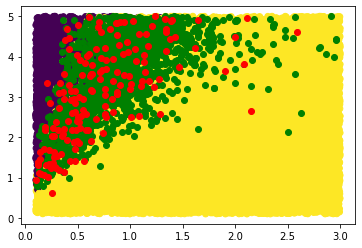

In [9]:
var = dataframe.relative_duration
amp = dataframe.relative_depth
detect = dataframe.nuance_detected
non_by_wotan = dataframe[non_wotan][["relative_duration", "relative_depth"]].values.T
non_by_nuance = dataframe[non_nuance][["relative_duration", "relative_depth"]].values.T

plt.scatter(var, amp, c=detect)
plt.scatter(*non_by_wotan, c="green")
plt.scatter(*non_by_nuance, c="red")